In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks")

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from LSTM.ConvLSTM_2 import *
from tqdm import tqdm
from time import sleep
import math
from LSTM.torch_early_stopping import  EarlyStopping
import json 
import random
import matplotlib.pyplot as plt
from LSTM.opt_and_loss import mape, loss_fn
from LSTM.forecasting import forecast_runner

import seaborn as sns 
from IPython.display import clear_output

In [ ]:
npy_path = npy_path = '/content/drive/MyDrive/Colab Notebooks/datasets/qlstm_def'
test_data = (np.load(npy_path+'/enc_in_test.npy'),
            np.load(npy_path+'/dec_in_test.npy'), 
            np.load(npy_path+'/dec_out_test.npy'))

dec_in_min = np.load(npy_path+'/dec_in_min.npy')
dec_in_max = np.load(npy_path+'/dec_in_max.npy')

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
	torch.set_default_tensor_type(torch.cuda.FloatTensor)
	device = 'cuda'
	print('cuda avaible')

In [ ]:
enc_in, dec_in, lab = test_data
enc_in, dec_in, lab = map ( lambda x : torch.from_numpy(x).float().to(device), [enc_in, dec_in, lab] )

In [ ]:
n_batch_considered=35

In [ ]:
enc_in=enc_in[:16*n_batch_considered]
dec_in=dec_in[:16*n_batch_considered]
lab=lab[:16*n_batch_considered]

In [ ]:
n_inputs =  enc_in.shape[2] #data_meta_info['n_inputs']
n_outputs = dec_in.shape[2] #data_meta_info['n_outputs']
window_dec = 5 #data_meta_info['window_dec']

hidden_dimensions=30
kernel_dim = 3

In [ ]:
saved_model_path = "/content/drive/MyDrive/Colab Notebooks/Thesis utils/Models dict/Enc_3gates_C/30_3_E3_LSTM_for.pt"
model = EncDecConvLSTM( device, n_inputs, hidden_dimensions, n_outputs, kernel_dim)
model.load_state_dict( torch.load(saved_model_path , map_location=device) )
model.to(device)

EncDecConvLSTM(
  (encoder): ENC_ConvLSTM(
    (forget): Conv2d(37, 30, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (input): Conv2d(37, 30, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (candidate): Conv2d(37, 30, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (output): Linear(in_features=37, out_features=30, bias=True)
  )
  (decoder): DEC_ConvLSTM(
    (out): Conv2d(30, 31, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (lin_1): Linear(in_features=31, out_features=1, bias=True)
    (forget): Linear(in_features=31, out_features=30, bias=True)
    (input): Linear(in_features=31, out_features=30, bias=True)
    (candidate): Linear(in_features=31, out_features=30, bias=True)
    (output): Linear(in_features=31, out_features=30, bias=True)
  )
)

In [ ]:
test_set = torch.utils.data.TensorDataset(enc_in, dec_in, lab)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 16)

In [ ]:
pred,lab, pred_l, lab_l=forecast_runner(test_loader,model,device,window_dec,dec_in_min,dec_in_max,n_batch_considered)

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter 

In [ ]:
def dynamic_heatmaps(true, pred, n_data_show=0, delay=0.5, out_feature_show=0):
    pt= "/content/drive/MyDrive/Colab Notebooks/LSTM/predictions"
    true = true[n_data_show,:,out_feature_show,:,:]
    pred = pred[n_data_show,:,out_feature_show,:,:]

    vmax = max(true.max(), pred.max())
    vmin = min(true.min(), pred.min())

    for i in range(pred.shape[0]):

      clear_output(wait=True)
      time.sleep(delay)
      
      fig, axes = plt.subplots(ncols=2, figsize=(12, 12))
      ax1, ax2 = axes

      true_temp=true[i,:,:]
      pred_temp=pred[i,:,:]

      # Heat maps.
      im1 = ax1.matshow(true_temp, cmap='coolwarm', vmin=vmin, vmax=vmax)
      im2 = ax2.matshow(pred_temp, cmap='coolwarm', vmin=vmin, vmax=vmax)

      # Formatting for heat map 1.
      # ax1.set_xticks(range(len(columns1)))
      # ax1.set_yticks(range(len(columns1)))
      # ax1.set_xticklabels(columns1)
      # ax1.set_yticklabels(columns1)
      # ax1.set_title(data1.name, y=-0.1)
      # plt.setp(ax1.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
      plt.colorbar(im1, fraction=0.045, pad=0.05, ax=ax1)

      # Formatting for heat map 2.
      # ax2.set_xticks(range(len(columns2)))
      # ax2.set_yticks(range(len(columns2)))
      # ax2.set_xticklabels(columns2)
      # ax2.set_yticklabels(columns2)
      # ax2.set_title(data2.name, y=-0.1)
      # plt.setp(ax2.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
      plt.colorbar(im2, fraction=0.045, pad=0.05, ax=ax2)
      plt.savefig(pt+'/'+str(i)+'.JPG')

      fig.tight_layout()
      #display(fig)
      plt.show()


In [ ]:
import time

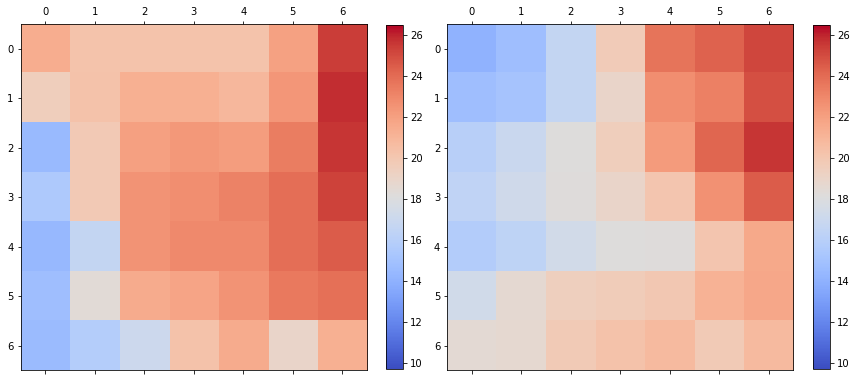

In [ ]:
_,_,test_label = test_data
#while True:
dynamic_heatmaps(test_label, forecasted_label.detach().numpy(),3)

In [ ]:
import glob
from PIL import Image
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.JPG")]
    frame_one = frames[0]
    frame_one.save("/content/drive/MyDrive/Colab Notebooks/LSTM/predictions/Fourth_TRY.gif", format="GIF", append_images=frames,
               save_all=True, duration=500, loop=0)
    
if __name__ == "__main__":
    make_gif("/content/drive/MyDrive/Colab Notebooks/LSTM/predictions")

In [ ]:
forecasted_label_p= np.transpose( pred_l.detach().numpy(),axes=(3,4,0,1,2))

In [ ]:
test_label_p= np.transpose( lab_l,axes=(3,4,0,1,2))


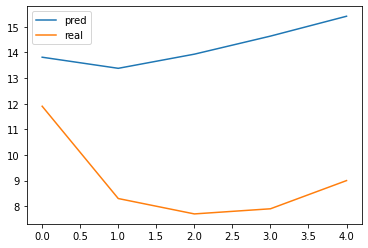

In [ ]:
plt.plot(forecasted_label_p[0][3][7],label='pred')
plt.plot(test_label_p[0][3][7],label='real')
plt.legend()

In [ ]:
def percentage_accuracy(pred,dec_out,delta,epsilon):
    pred=np.transpose(pred,axes=(3,4,0,1,2))
    dec_out=np.transpose(dec_out,axes=(3,4,0,1,2))
    pred=pred.squeeze(axis=4)
    dec_out=dec_out.squeeze(axis=4)
    radom = np.abs(pred-dec_out)/(np.abs(pred)+epsilon)
    ones=np.where(radom<delta,1,0)
    sum=np.sum(ones,axis=3)
    ones_2=np.where(sum==ones.shape[3],1,0)
    percentage=np.sum(ones_2,axis=2)/ones_2.shape[2]

    return percentage

In [ ]:
percentage_matrix=percentage_accuracy(test_label,forecasted_label.detach().numpy(),0.2,1e-9)

NameError: ignored

In [ ]:
import seaborn as sns

<AxesSubplot:>

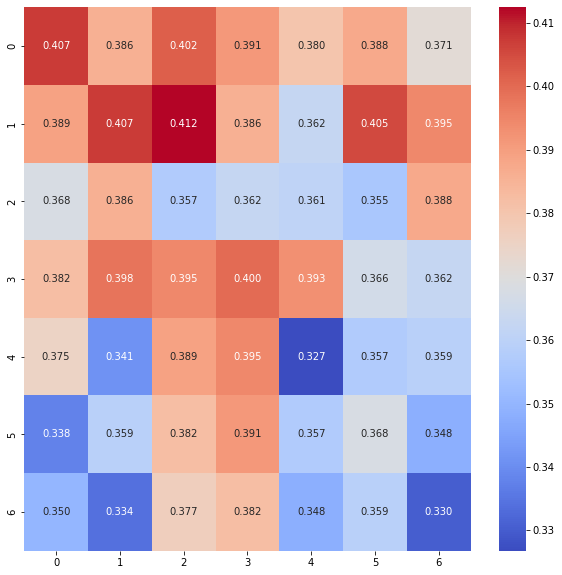

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(percentage_matrix, annot=True, fmt=".3f",cmap='coolwarm')

In [ ]:
MAPE=mape(pred,lab)
mape_mean=MAPE.mean()
mape_max=MAPE.max()
mape_min=MAPE.min()

In [ ]:
print(mape_min)
print(mape_max)
print(mape_mean)

17.499603
21.346712
19.072254


In [1]:
plt.figure(figsize=(6,6))
plt.title("EnDec3-C-LSTM")
sns.heatmap(MAPE, annot=False, fmt=".3f",cmap='coolwarm')

NameError: ignored

In [ ]:
MAPE.mean()

19.072254

In [ ]:
loss_mean=loss_fn(pred_l,lab_l)
print(loss_mean)

tensor(2.7893, grad_fn=<MeanBackward0>)


In [ ]:
mse=torch.nn.MSELoss()
rmse_mean=torch.sqrt(mse(lab_l,pred_l))
print(rmse_mean)

tensor(4.5451, grad_fn=<SqrtBackward0>)


In [ ]:
#npy_path = npy_path = '/content/drive/MyDrive/Colab Notebooks/Thesis utils/MATRIX_TEST/DFC/rmse_matrix.npy'
rmse_matrix=np.load('/content/drive/MyDrive/Colab Notebooks/Thesis utils/MATRIX_TEST/DENSE/rmse_matrix.npy')

In [ ]:
rmse_matrix

array([[5.29311514, 5.23631811, 5.20985746, 4.81825542, 4.40456486],
       [5.4287653 , 5.02391911, 4.59894705, 5.47979164, 4.52949667],
       [5.46628571, 5.51006508, 4.62717533, 4.53827763, 4.77800941],
       [5.66901064, 4.74504471, 5.1515317 , 4.67589855, 4.82533216]])